In [22]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.special import jv, yv
from scipy.stats import qmc
import warnings
from scipy.integrate import quad_vec
import functools
import time

#This function is used to calculate the Mie coefficients a_n and b_n.
#For reference, see the book Bohren & Huffman. The basic solution is given
#in equation (4.53). The version implemented here is from equations
#(4.56) and (4.57), which assume the permeability of particle and
#surrounding medium to be the same!! This is an ASSUMPTION.

#To compute the coefficients we use the equations given in section
#4.8 of the book.

#Inputs: m is the (complex) refractive index of the particle, x is the
#size parameter calculated as 2 * pi * n * r / lambda, and n is the
#refractive index of the medium (assumed to be 1 by default here), r
#is the particle size (radius) and lambda the wavelength of the incoming light
def MieCoefficients_ab(m,x,c=1,mediumindex=1):
    start_time = time.time()
    #for x correctly
    x = x* mediumindex.real
    m = m/ mediumindex.real
    mx = m*x

    #A good rule of thumb is that we need about x (size parameter) terms for
    #the sum to give good reslts (start of section 4.8 in Bohren and Huffman)
    #so we set the max sum index to the expression below.
    #c is 1 per default but can be changed in the function input increase
    #the upper bound of the summation.
    nmax = np.amax(np.round(c*(2+x+4*(x**(1/3)))))
    mxmax = np.amax(np.round(np.abs(mx)))

    #this will be used as the max index for the calculation of the
    #D_n below, given in eq. (4.89). The +16 terms are used for initialization
    #and will be dropped later. (see calculation of Dn below)

    nmax_Dn = np.round(max(nmax,mxmax)+16)

    #this will give us the index for the bessel/hankel/etc. functions
    n = np.arange(1,nmax+1) #
    nu = n + 0.5 #
    nu = nu[np.newaxis]
    n = n[np.newaxis]
    #this is the prefactor used to convert the normal bessel functions into
    #the so called Riccati Bessel functions. These are defined in Bohren and
    #Huffman right above equation (4.56)
    prefactor = np.sqrt(0.5*np.pi*x)

    #Here we define the Ricatti functions. The second line is needed because
    #we start at n=1 but we need to add the zeroth function, which is sin(x) for
    #the Ricatti function dubbed Sn and cos(x) for Cn. This effectively shifts
    #the index by 1, which is exactly what we need for the formula (4.88) in
    #the book
    RicattiSn = prefactor*jv(nu.T,x) #
    RicattiSn0 = np.insert(RicattiSn, 0, np.sin(x), 0)
    RicattiSn0 = np.delete(RicattiSn0, -1, 0) #

    RicattiCn = -prefactor*yv(nu.T,x) #
    RicattiCn0 = np.insert(RicattiCn, 0, np.cos(x), 0)
    #RicattiCn0 = np.append(np.cos(x), RicattiCn[0:int(nmax)-1]) #
    RicattiCn0 = np.delete(RicattiCn0, -1, 0)

    RicattiXin = RicattiSn-(0+1j)*RicattiCn #
    RicattiXin0 = RicattiSn0-(0+1j)*RicattiCn0 #

    #Here we add an axis to be able to do the .T command later, where we want to
    #subtract for example the first element from all the columns in the first row.
    #this is done by subtracting a row-vector from the matrix

    #here we define Dn, which is a quantity also needed to calculate the
    #coefficients in (4.88), and the definition of Dn is given in (4.89).
    #each term in the recurrence relation reduces the error signigicantly,
    #which is why here I initiate with zero and calculate more terms then
    #necessary and in the end throw away the first few terms.
    D_n = np.zeros((int(nmax_Dn),len(m)),dtype=complex)
    for i in range(int(nmax_Dn)-1,1,-1):
        D_n[i-1,:] = (i/mx)-(1/(D_n[i,:]+i/mx))


    #Here we drop the terms beyond nmax that we needed to initialize and we
    #start at index 1 because there is no a0 but we start with n=1.
    D_n = D_n[1:int(nmax)+1,:]

    #Here I just define the two factors in brackets from eq. (4.88)
    #Python is amazing here because the array-matrix multiplication does
    #exactly what we want here. multiplying an array with a matrix,
    #the rows are multiplied elementwise with the array and this happens for
    #every row, which is exactly what we want.
    FactorFora_n = D_n/m + n.T/x
    FactorForb_n = m*D_n + n.T/x

    #Now, finally, calculating the coefficients according to eq. (4.88) :D
    a_n = (FactorFora_n*RicattiSn - RicattiSn0) / (FactorFora_n*RicattiXin-RicattiXin0)
    b_n = (FactorForb_n*RicattiSn - RicattiSn0) / (FactorForb_n*RicattiXin-RicattiXin0)
    end_time = time.time()
    print('Mie_coefficients_ab',end_time - start_time)
    return a_n, b_n



#Here I define a function which is used to calculate the same coefficients as before
#but with the simplifying assumption that we have small particles (compared to the wavelength)
#which means we can approximate the whole thing by just the first few terms.
#This is done in section 5.1 in Bohren and Huffman.
def LowFrequencyMieCoefficients_ab(m,x,mediumindex=1):
    start_time = time.time() 
    x = x* mediumindex.real
    m = m/ mediumindex.real

    a_1 = (-2j/3) * x**3 * (m**2-1)/(m**2+2)  -  (2j/5) * x**5  * (m**2-1)*(m**2-2)/(m**2+2)**2  +  (4/9) * x**6 * ((m**2-1)/(m**2+2))**2

    b_1 = (-1j/45) * x**5 * (m**2-1)

    a_2 = (-1j/15) * x**5 * (m**2-1)/(2*m**2+3)

    b_2 = 0+0j

    a_n = np.vstack((a_1,a_2))
    b_n = np.vstack((b_1,b_2))
    return a_n , b_n

#This function automatically decides to use the low-frequency approximation if the
#size parameter is smaller than limit, which is set to 0.5 by default. There is
#also an option to switch auto to False, in which case only the full treatment is
#used and no low frequency approximation is used even for small particles.
def AutomaticMieCoefficients_ab(m,x,c=1,mediumindex=1,limit=0.5,auto=True):
    start_time = time.time()
    minimum = np.amin(np.abs(x))
    if auto:
        if minimum<limit:
          return LowFrequencyMieCoefficients_ab(m,x,mediumindex)
        else:
          return MieCoefficients_ab(m,x,c,mediumindex)
    else:
        return MieCoefficients_ab(m,x,c,mediumindex)


#Here the angle-dependent functions pi_n and tau_n are calculated
#via a recursion relation as shown in equation (4.47)
def PiTau(angle,nmax):
    start_time = time.time()
    mu = np.cos(angle/180*np.pi)

    #This creates a 2D array with zeroes where the columns are the angles
    #(which is why there are 180 columns) and the rows are the pi_n and tau_n
    #for every angle
    pi = np.zeros((int(nmax),len(angle)))
    tau = np.zeros((int(nmax),len(angle)))

    #Here I calculate the first two elements according to relation (4.47) in
    #the book. Caveat!: the zeroth index is actually the element pi_1, tau_1.
    #this is because in the sum we start with n=1 so we don't consider n=0,
    #but it is nevertheless used to calculate n=1 via the relation (4.47)
    pi[0,:] = 1
    pi[1,:] = 3*mu

    tau[0,:] = mu
    #tau[1,:] = 3*(2*mu**2-1)
    tau[1,:] = 3.0*np.cos(2*np.arccos(mu))

    #After initializing the first few elements, now the rest is calculated
    #with the aforementioned recurrence relation
    #Caveat!: the element at index n=0 is actually the term for n=1. so
    #when calculating pi_n, we need to replace n in (4.47) by n+1, because
    #our index lags one behind (index 0 is actually for n=1, etc.)
    for n in range(2,int(nmax)):
        pi[n,:] = (2*n+1)/n * (mu*pi[n-1,:]) - (n+1)/n * pi[n-2,:]
        tau[n,:] = (n+1)*mu * pi[n,:] - (n+2) * pi[n-1,:]
    return pi, tau


#Here the Matrix Elements of the Scattering (2x2) matrix are calculated.
#The formulas for these matrix elements are given in equation (4.74)
#from these formulas we can then calculate the phase functions in the
#mueller matrix
def ScatteringMatrixElements(m,x,angle,c=1,n=1,limit=0.5,auto=True):
    start_time = time.time()
    xmax = np.amax(x)
    nmax = np.round(c*(10+xmax+4*np.power(xmax,1/3)))

    #determine the coefficients used to calculate the matrix elements S1 and S2
    #see function description for MieCoefficients_ab above
    a_n, b_n = MieCoefficients_ab(m,x,c,n)
    a_n = a_n[:,np.newaxis,:]
    b_n = b_n[:,np.newaxis,:]

    #Calculate the functions pi and tau needed for the calculation.
    #see function description for PieTau above
    pi_n, tau_n = PiTau(angle,nmax)

    #This gives the matrix a new (3rd) axis. This is needed because we multiply
    #with the a_n and b_n later. why? --> we have two matrices: the pi/tau_n
    #which are all the n's for every angle, and the an/bn, which are all the
    #n's for every refractive index. we now need to multiply the first entry
    #of the pi_n matrix (=pi_1 for angle theta=1) with the entire first row
    #of the index vs. an matrix in order to get pi_1*a_1 at angle theta = 1
    #for every refractive index in the matrix. So every angle gives an entirely
    #new matrix and in the end we have a rank 3 tensor.
    #when we then sum over one axis of this rank 3 tensor, we are left with
    #a rank 2 tensor (=matrix) whose elements then are the ScatteringMatrixElements
    #for each refractive index and each angle. The rows will be the angles
    #and the columns will be the different refractive indices
    pi_n = pi_n[:,:,np.newaxis]
    tau_n = tau_n[:,:,np.newaxis]

    #Here I create an array for the summation in formula (4.74)
    #remember that for all our quantities, the zero-index value is actually
    #the n=1 value. So here an array is created with numeric value 1 in its
    #first entry (= zeroth index) in order to sum properly according to formula (4.74)
    n = np.arange(1,int(nmax)+1)

    #this is the prefactor in the sum (4.74) and needs to be transposed with
    #the nexaxis command in order to multiply the correct entries in the rank 3
    #tensor below
    Prefactor = (2*n+1)/(n*(n+1))
    Prefactor = Prefactor[np.newaxis,np.newaxis]
    Prefactor = Prefactor.T

    #a_n is a matrix with the columns being different refractive indices and the
    #rows being the a_n for these indices, so I need the number or rows to know
    #how many a_n there are, to know until what n to sum.
    UpperSumIndex_a = np.shape(a_n)[0]
    UpperSumIndex_b = np.shape(b_n)[0]

    #finally, actual calculation of the sum (4.74) to get the matrix elements S1 and S2 ;)
    S_1 = np.sum(Prefactor[0:UpperSumIndex_a] * ( pi_n[0:UpperSumIndex_a,:] * a_n + tau_n[0:UpperSumIndex_b,:] * b_n),0)
    S_2 = np.sum(Prefactor[0:UpperSumIndex_a] * (tau_n[0:UpperSumIndex_a,:] * a_n + pi_n[0:UpperSumIndex_b,:] * b_n),0)

    #The returned matrices will have the S-values as entries. Since S depends on the angle and the
    #refractive index, we have "two dimensions". The columns will correspond to different refractive
    #indices and the rows will correspond to different angles. so the entry M_57 in the matrix
    #will be the S-element for the angle of 5 degrees of the 7th refractive index in the data set
    return S_1, S_2


#Here we use equation(s) (4.77) in the book to get the two elements we want
#we want S11 and -S12/S11, which is the polarized phase function
#the radius and the wavelength have to be input with the same units. so if one
#used nanometers for the wavelength, the particle radius needs to be nanometers as well.
def PhaseFunctions(m,wavelength,radius,angle,mediumindex=1.0,limit=0.5,auto=True,c=1):
    start_time = time.time()
    #n = n.real
    wavelength = wavelength/mediumindex.real
    x = 2*np.pi*radius/wavelength

    S_1, S_2 = ScatteringMatrixElements(m,x,angle,c,mediumindex,limit,auto)

    S_11 = 0.5*(np.abs(S_2)**2+np.abs(S_1)**2)
    S_12 = 0.5*(np.abs(S_2)**2-np.abs(S_1)**2)

    #PPF: polarized phase function
    PPF = -S_12/S_11

    return S_11, PPF



#This function integrates over a particle size distribution
#def sizedistribution(r, Vtot, sigma, rmean):
#    start_time = time.time()
#    return Vtot/(np.sqrt(2*np.pi)) * 1/sigma * 1/(r/1000) * np.exp(-(np.log(r)-np.log(rmean))**2/(2*sigma**2))

#This creates a matrix where every row is a new set of parameters and every column consists of different values for the
#same parameter. It uses LatinHypercube sampling, meaning (roughly) it chooses random values from a n-dimensional cube with
#specific size-bounds that can be set in the input
def CreateParameterMatrix(SampleSize, RealIndexBounds, ImaginaryIndexBounds, SigmaBounds, MeanRadiusBounds, VolumeConcentrationBounds):
    start_time = time.time()
    #This creates a matrix with random entries which has 5 columns (=number of parameters we want)
    #and as many rows as we want to, which will correspond to the samplesize we choose
    sampler = qmc.LatinHypercube(d=5, seed = 1)
    sample = sampler.random(n=SampleSize)

    #This creates the lower and upper bounds for the parameters which are also taken as input values
    LowerBounds = np.array([RealIndexBounds[0], ImaginaryIndexBounds[0], SigmaBounds[0], MeanRadiusBounds[0], VolumeConcentrationBounds[0]])
    UpperBounds = np.array([RealIndexBounds[1], ImaginaryIndexBounds[1], SigmaBounds[1], MeanRadiusBounds[1], VolumeConcentrationBounds[1]])

    #This rescales all the created random values in the matrix to match the lower and upper bounds that we set
    sample = qmc.scale(sample, LowerBounds, UpperBounds)

    #This makes a pandas dataframe out of the sample matrix
    Data = pd.DataFrame(sample, columns=['RealRefractiveIndex', 'ImaginaryRefractiveIndex', 'Sigma', 'MeanRadius', 'VolumeConcentration'])

    return Data


def SinglePhaseFunctionsFromParameterSet(ParameterSet, wavelength, mediumindex=1.0, limit=0.5, auto=True, c=1):
    start_time = time.time()
    RefractiveIndex = ParameterSet['RealRefractiveIndex'].to_numpy() + (0+1j)*ParameterSet['ImaginaryRefractiveIndex'].to_numpy()
    RelativeIndex = RefractiveIndex/mediumindex

    Radius = ParameterSet['MeanRadius'].to_numpy()

    Angles = np.arange(1,180)

    S_11, PPF = PhaseFunctions(RelativeIndex,wavelength,Radius,Angles,mediumindex=mediumindex,limit=limit,auto=auto,c=c)

    return S_11, PPF


def sizedistribution(r, Vtot, sigma, rmean):
    return Vtot/(np.sqrt(2*np.pi)) * 1/sigma * 1/r * np.exp(-(np.log(r)-np.log(rmean))**2/(2*sigma**2))

def integrand(radius, m, wavelength, mediumindex, angle, Vtot, sigma, rmean, c, limit, auto):

            wavelength = wavelength/mediumindex.real
            x = 2*np.pi*radius/wavelength

            S_1, S_2 = ScatteringMatrixElements(m,x,angle,c,mediumindex,limit,auto)

            S_11 = 0.5*(np.abs(S_2)**2+np.abs(S_1)**2)
            S_12 = 0.5*(np.abs(S_2)**2-np.abs(S_1)**2)

            #PPF: polarized phase function
            PPF = -S_12/S_11

            return (S_11*sizedistribution(radius, Vtot, sigma, rmean))
    
def EnsemblePhaseFunctions(m, wavelength, Vtot, sigma, rmean, radiusbounds = np.array([50,3000]),angle=np.arange(1,181), mediumindex=1.0, limit=0.5, auto=True, c=1):

    PartialIntegrand = functools.partial(integrand, m=m, wavelength=wavelength, mediumindex=mediumindex, angle=angle, Vtot=Vtot, sigma=sigma, rmean=rmean, c=c, limit=limit, auto=auto)

    IntegratedMatrix = quad_vec(PartialIntegrand,radiusbounds[0],radiusbounds[1],workers=-1)

    return IntegratedMatrix

def IntegratedEnsembleMatrixFromParameterSet(ParameterSet, wavelength, radiusbounds = np.array([50,3000]), angles = np.arange(1,181), mediumindex=1.0, limit=0.5, auto=True, c=1):

        RefractiveIndex = ParameterSet['RealRefractiveIndex'].to_numpy() + (0+1j)*ParameterSet['ImaginaryRefractiveIndex'].to_numpy()
        RelativeIndex = RefractiveIndex/mediumindex
        Vtot = ParameterSet['VolumeConcentration'].to_numpy()
        sigma = ParameterSet['Sigma'].to_numpy()
        rmean = ParameterSet['MeanRadius'].to_numpy()

        IntegratedMatrix = EnsemblePhaseFunctions(RelativeIndex, wavelength, Vtot, sigma, rmean, radiusbounds=radiusbounds, angle=angles, mediumindex=mediumindex, limit=limit, auto=auto, c=c)

        return IntegratedMatrix

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Mie Package Documentation

#### This Notebook explains the main functions present in the MiePackage script - how to use them and what they do.

#### Let's start with the function *ScatteringMatrixElements(m,x,angle,c=1,n=1,limit=0.5,auto=True):*

It calculates the Matrix Elements S1 and S2 of the Scattering Matrix, which is the 2x2 Matrix acting on the vector with components of the parallel and perpendicular electric field. These elements can be used on their own but are also used in another function to directly calculate P11 and P12, which are the matrix elements we are interested in.

The inputs are

- m: refractive index of particle / medium refractive index
- x: size parameter
- angle: an array from 1 to 180 (or whatever angles you want)
- c: higher values compute higher limits of the sum
- n: refractive index of the medium

The size parameter is calculated with x = 2 * pi * R / lambda, where R is the particle radius (sphere) and lambda the incident wavelength.

Mie_coefficients_ab 0.08893299102783203


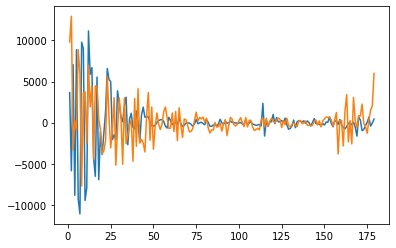

In [14]:
m = np.array([1.2,1.5])
wavelength = 532
particleradius = 700
x = 2*np.pi*particleradius
angle = np.arange(1,180)


S1, S2 = ScatteringMatrixElements(m,x,angle,c=1,n=1)

plt.figure()
plt.plot(angle, S1.real)

As can be seen, S1 has elements for all the angles form 1 to 180 for both refractive indices (since we used an array with two entries for m as input)

#### The PhaseFunctions(m,wavelength,radius,angle,mediumindex=1.0,c=1) function directly calculates the S1 and S2 and uses them to calculate P11 and PPF (= -P12/P11), which is what we actually want.

Mie_coefficients_ab 0.0013246536254882812


Text(0.5, 1.0, 'Polarized Phase Function')

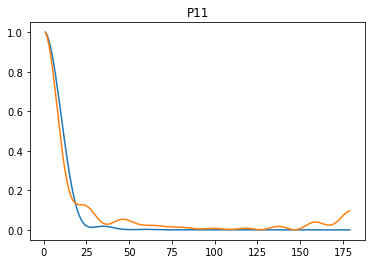

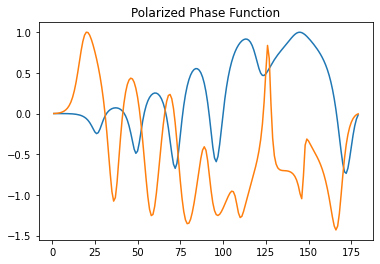

In [15]:
P11, PPF = PhaseFunctions(m,wavelength,particleradius,angle)

plt.figure()
plt.plot(angle, P11[:,0]/max(P11[:,0]))
plt.plot(angle, P11[:,1]/max(P11[:,1]))
plt.title('P11')

plt.figure()
plt.plot(angle, PPF[:,0]/max(PPF[:,0]))
plt.plot(angle, PPF[:,1]/max(PPF[:,1]))
plt.title('Polarized Phase Function')

#### Now lets say we want to create our own dataset. This can be done with the CreateParameterMatrix()-function

It has the following inputs:

- Samplesize: How many samples you want
- RealIndexBounds: an array with two entries which confine the real part of the refractive index in your sample
- ImaginaryIndexBounds: same as RealIndexBounds but for imaginary part
- SigmaBounds: same as the other bounds but for the sigma of the size distribution you are using
- MeanRadiusBounds: you get it.. ;)
- VolumeConcentrationbounds: ..

In [16]:
SampleSize = 20
RealIndexBounds = np.array([1.3,1.8])
ImaginaryIndexBounds = np.array([0.0,0.2])
SigmaBounds = np.array([1.30,1.50])
MeanRadiusBounds = np.array([100,3000])
VolumeConcentrationBounds = np.array([1,5000])


Parameters = CreateParameterMatrix(SampleSize, RealIndexBounds, ImaginaryIndexBounds, SigmaBounds, MeanRadiusBounds, VolumeConcentrationBounds)


In [17]:
Parameters.columns = ['RealRefractiveIndex', 'ImaginaryRefractiveIndex', 'Sigma','MeanRadius', 'VolumeConcentration']
Parameters

RealRefractiveIndex  ImaginaryRefractiveIndex     Sigma   MeanRadius  \
0              1.465638                  0.031334  1.331611   459.336976   
1              1.584620                  0.040613  1.440930   817.983146   
2              1.752132                  0.116510  1.313781  2115.994373   
3              1.543168                  0.013296  1.364393  1689.302997   
4              1.615486                  0.070649  1.384926  1542.783583   
5              1.792495                  0.174315  1.422491   913.003779   
6              1.636038                  0.192611  1.451504  2267.708916   
7              1.714835                  0.063707  1.356011  1723.507265   
8              1.444476                  0.090058  1.408519   346.530798   
9              1.364390                  0.020730  1.480620  1343.986556   
10             1.402894                  0.133679  1.376882  2539.007524   
11             1.684284                  0.127855  1.431213  1148.430871   
12             1.300964                  0.152204  1.460788  2926.865341   
13             1.730539                  0.055719  1.496202  2641.498472   
14             1.563249                  0.086668  1.324586  2378.951230   
15             1.495184                  0.167210  1.413596   679.117955   
16             1.503106                  0.144091  1.303856   203.149092   
17             1.381516                  0.105980  1.476310  1974.096760   
18             1.652228                  0.180312  1.347364  1106.913575   
19             1.349155                  0.009650  1.398616  2832.154958   

    VolumeConcentration  
0           3266.412543  
1           4575.784218  
2           1897.701184  
3            859.407704  
4           4787.555586  
5            637.187730  
6            169.369130  
7           2659.400857  
8           3193.340111  
9           1308.731652  
10          2331.824194  
11          3553.225347  
12          2755.611368  
13          1178.432625  
14          2034.985675  
15           496.151368  
16          1737.274182  
17          3791.497994  
18          4429.655097  
19          4118.258252

As you can see, 12 sets of parameters have been created with values between the given bounds.

#### Using this Parameterset we can directly input it into the SinglePhaseFunctionsFromParameterSet()-function to get the Phase Functions for a single radius (meaning *not* averaged over the size distribution.

Mie_coefficients_ab 0.005671977996826172


Text(0.5, 1.0, 'Polarized Phase Functions')

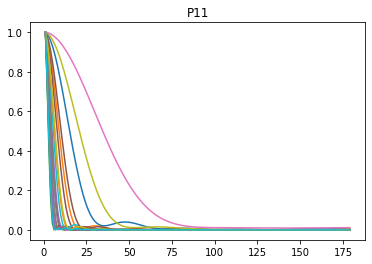

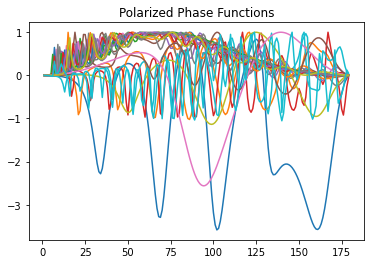

In [18]:
P11, PPF = SinglePhaseFunctionsFromParameterSet(Parameters, wavelength)

plt.figure()
for i in range(len(P11[1,:])):
    plt.plot(angle, P11[:,i]/max(P11[:,i]))
plt.title('P11')
    
plt.figure()
for i in range(len(PPF[1,:])):
    plt.plot(angle, PPF[:,i]/max(PPF[:,i]))
plt.title('Polarized Phase Functions')

#### If we want an Ensemble Average over a size distribution we can use the IntegratedEnsembleMatrixFromParameterSet()-function and input our parameterset.

In [19]:
wavelength = 532
Ensemble = IntegratedEnsembleMatrixFromParameterSet(Parameters, wavelength)[0]

Mie_coefficients_ab 0.0027005672454833984
Mie_coefficients_ab 0.0008428096771240234
Mie_coefficients_ab 0.0009903907775878906
Mie_coefficients_ab 0.0007929801940917969
Mie_coefficients_ab 0.0008189678192138672
Mie_coefficients_ab 0.0007536411285400391
Mie_coefficients_ab 0.0007109642028808594
Mie_coefficients_ab 0.0007321834564208984
Mie_coefficients_ab 0.0006647109985351562
Mie_coefficients_ab 0.0005972385406494141
Mie_coefficients_ab 0.0005922317504882812
Mie_coefficients_ab 0.0005481243133544922
Mie_coefficients_ab 0.0004992485046386719
Mie_coefficients_ab 0.0004239082336425781
Mie_coefficients_ab 0.00040340423583984375
Mie_coefficients_ab 0.0004277229309082031
Mie_coefficients_ab 0.0003643035888671875
Mie_coefficients_ab 0.000331878662109375
Mie_coefficients_ab 0.0003173351287841797
Mie_coefficients_ab 0.00029659271240234375
Mie_coefficients_ab 0.0002963542938232422
Mie_coefficients_ab 0.0011014938354492188
Mie_coefficients_ab 0.0006387233734130859
Mie_coefficients_ab 0.00059485435

 Mie_coefficients_ab 0.00032639503479003906Mie_coefficients_ab  0.0010137557983398438

Mie_coefficients_abMie_coefficients_ab  0.00084686279296875
0.00070261955261230470.0012872219085693360.0006320476531982422

Mie_coefficients_abMie_coefficients_ab 0.0007984638214111328
Mie_coefficients_ab
Mie_coefficients_ab  0.00164461135864257810.0008959770202636719

 Mie_coefficients_ab0.0005819797515869141Mie_coefficients_ab Mie_coefficients_ab 
0.0010631084442138672
0.0012922286987304688 0.0008630752563476562Mie_coefficients_ab

Mie_coefficients_ab 0.0007452964782714844
Mie_coefficients_ab Mie_coefficients_abMie_coefficients_ab  0.0014925003051757812
 0.00091481208801269530.0013620853424072266Mie_coefficients_ab

 0.000995635986328125
Mie_coefficients_ab0.0005443096160888672Mie_coefficients_ab  0.001268625259399414

Mie_coefficients_ab0.0009899139404296875Mie_coefficients_ab 
0.001430511474609375
Mie_coefficients_abMie_coefficients_ab Mie_coefficients_ab 0.00169110298156738280.001246213912963867

Mie_coefficients_ab0.0015892982482910156Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab0.0011947154998779297   

Mie_coefficients_ab Mie_coefficients_ab 0.0008311271667480469Mie_coefficients_ab0.00098347663879394530.0010304450988769531 0.0011904239654541016 

0.00150704383850097660.001241922378540039
 
0.0008139610290527344
Mie_coefficients_abMie_coefficients_abMie_coefficients_ab
Mie_coefficients_ab
 Mie_coefficients_abMie_coefficients_ab0.0013096332550048828  Mie_coefficients_ab 
 0.00056552886962890620.0012784004211425781 0.0009315013885498047
 0.0010206699371337890.0013086795806884766Mie_coefficients_ab
 
0.0013151168823242188Mie_coefficients_abMie_coefficients_ab0.0008311271667480469  



0.0029366016387939453Mie_coefficients_abMie_coefficients_ab 0.0015735626220703125Mie_coefficients_ab0.0011141300201416016Mie_coefficients_ab 
0.0008060932159423828 
Mie_coefficients_ab Mie_coefficients_ab0.000801086425781250.00058746337890625
0.00164794921875 

Mie_co

 0.0012340545654296875 Mie_coefficients_ab0.0016047954559326172
 0.0015785694122314453Mie_coefficients_ab0.0014884471893310547
0.0007119178771972656Mie_coefficients_ab 
 0.00112152099609375
Mie_coefficients_ab 
0.0012891292572021484

Mie_coefficients_ab0.001047372817993164Mie_coefficients_ab 
Mie_coefficients_ab  Mie_coefficients_ab0.0006334781646728516 0.0019047260284423828 0.0011343955993652344Mie_coefficients_abMie_coefficients_ab0.0010347366333007812


0.0015864372253417969Mie_coefficients_ab 


  Mie_coefficients_ab0.0007107257843017578Mie_coefficients_ab
0.0012674331665039062 Mie_coefficients_ab0.0011034011840820312Mie_coefficients_ab Mie_coefficients_ab
Mie_coefficients_ab0.0017604827880859375 
0.0013492107391357422 
 0.0049896240234375Mie_coefficients_ab0.0014357566833496094Mie_coefficients_ab  0.00160717964172363280.0013005733489990234Mie_coefficients_ab


 
0.004645586013793945
0.0006430149078369141Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab
M

0.0015087127685546875Mie_coefficients_ab
0.00101947784423828120.000881195068359375  
 
Mie_coefficients_ab0.00125765800476074220.0011272430419921875 Mie_coefficients_ab
0.0011479854583740234
 
Mie_coefficients_abMie_coefficients_ab


Mie_coefficients_ab 0.00054526329040527340.0015287399291992188 
0.0015213489532470703
0.0006768703460693359Mie_coefficients_ab Mie_coefficients_abMie_coefficients_ab0.0008246898651123047Mie_coefficients_ab  Mie_coefficients_ab0.0013093948364257812Mie_coefficients_ab

Mie_coefficients_ab Mie_coefficients_ab

 0.0013453960418701172 0.001359701156616211
  Mie_coefficients_ab0.002543210983276367 Mie_coefficients_abMie_coefficients_ab   
 Mie_coefficients_ab0.0013890266418457031
0.00116682052612304690.001520395278930664 Mie_coefficients_ab0.00133395195007324220.00085592269897460940.0007367134094238281 
0.00134611129760742190.002047300338745117
0.0015561580657958984
Mie_coefficients_ab0.0009338855743408203
 Mie_coefficients_ab0.0006132125854492188

0.00072622299

Mie_coefficients_ab 0.0013871192932128906Mie_coefficients_abMie_coefficients_abMie_coefficients_ab Mie_coefficients_ab0.00056529045104980470.0011243820190429688 
    
 
Mie_coefficients_abMie_coefficients_ab 0.00121784210205078120.0014371871948242188
Mie_coefficients_abMie_coefficients_ab0.0014464855194091797  0.0010471343994140625


0.00165867805480957030.00064492225646972660.0011482238769531250.0011129379272460938Mie_coefficients_ab0.0013265609741210938Mie_coefficients_abMie_coefficients_ab Mie_coefficients_ab



   0.0011699199676513672 0.00112056732177734380.0007278919219970703
Mie_coefficients_abMie_coefficients_ab
0.0009846687316894531

Mie_coefficients_ab 
Mie_coefficients_ab0.0017294883728027344Mie_coefficients_abMie_coefficients_ab0.000942230224609375 0.0015118122100830078Mie_coefficients_abMie_coefficients_ab Mie_coefficients_ab0.0006108283996582031 
Mie_coefficients_ab  Mie_coefficients_ab 0.001594543457031250.0013678073883056640.0006618499755859375 



0.0009617805480957031

Mie_coefficients_abMie_coefficients_ab0.0007898807525634766Mie_coefficients_abMie_coefficients_ab  0.0013699531555175781
0.0012121200561523438Mie_coefficients_ab0.00123929977416992190.00081896781921386720.0008764266967773438    




  
0.0016815662384033203

0.001325845718383789Mie_coefficients_ab0.0009629726409912109Mie_coefficients_abMie_coefficients_ab
0.002785921096801758 
 
 0.011569261550903320.002671957015991211Mie_coefficients_abMie_coefficients_abMie_coefficients_ab Mie_coefficients_abMie_coefficients_ab
Mie_coefficients_ab0.0007503032684326172Mie_coefficients_ab0.0030775070190429688
Mie_coefficients_ab Mie_coefficients_ab   
 
0.0014488697052001953Mie_coefficients_ab 0.0010488033294677734
   0.0007338523864746094 0.00473809242248535160.0011150836944580078Mie_coefficients_ab0.00104975700378417970.00141930580139160160.0014293193817138672

Mie_coefficients_ab
Mie_coefficients_ab 
Mie_coefficients_ab 0.0020356178283691406Mie_coefficients_ab0.00125765800476074220.00089693069458007

  Mie_coefficients_ab0.0014958381652832031Mie_coefficients_ab 0.02499842643737793Mie_coefficients_abMie_coefficients_ab
0.00145721435546875 Mie_coefficients_ab
0.0016896724700927734  
 0.01796412467956543Mie_coefficients_ab0.00235080718994140620.0013506412506103516
 
0.001210927963256836
 0.0033042430877685547Mie_coefficients_ab
0.0010499954223632812 
0.0009548664093017578

 Mie_coefficients_ab0.000997304916381836Mie_coefficients_ab  Mie_coefficients_ab0.0008022785186767578
0.0011487007141113281Mie_coefficients_ab 0.0009326934814453125Mie_coefficients_ab
0.00072979927062988280.0007696151733398438Mie_coefficients_ab

Mie_coefficients_ab 
Mie_coefficients_ab
 0.05217552185058594
0.02128577232360840.0007982254028320312 Mie_coefficients_abMie_coefficients_ab
 Mie_coefficients_abMie_coefficients_ab Mie_coefficients_ab
 
 

Mie_coefficients_ab0.0010690689086914062 0.0009794235229492188Mie_coefficients_abMie_coefficients_abMie_coefficients_ab0.0010318756103515625
0.0015134811401367188Mie_coef

0.0009398460388183594  Mie_coefficients_ab0.0006852149963378906Mie_coefficients_abMie_coefficients_ab0.00143480300903320310.00091552734375 Mie_coefficients_ab 0.0008480548858642578Mie_coefficients_ab0.0009584426879882812
0.0007622241973876953Mie_coefficients_ab 0.0019536018371582030.0012412071228027344Mie_coefficients_ab 0.0010840892791748047
Mie_coefficients_ab
Mie_coefficients_ab

  Mie_coefficients_ab0.0009310245513916016Mie_coefficients_ab0.0010633468627929688


0.00218057632446289060.0035419464111328125
  

 

  Mie_coefficients_abMie_coefficients_ab
0.00125360488891601560.00150990486145019530.00162386894226074220.0011188983917236328Mie_coefficients_ab0.0011055469512939453Mie_coefficients_ab 

  0.0012841224670410156Mie_coefficients_ab 
Mie_coefficients_ab 0.00150012969970703120.0007128715515136719  Mie_coefficients_abMie_coefficients_abMie_coefficients_ab
0.00082683563232421880.001218557357788086


Mie_coefficients_abMie_coefficients_abMie_coefficients_ab

Mie_coefficients_abMie_

0.00090003013610839840.00079059600830078120.0009357929229736328 
     Mie_coefficients_ab
Mie_coefficients_abMie_coefficients_ab0.0008919239044189453 0.003753185272216797
 
 0.00102090835571289060.0016112327575683594 
0.04580974578857422  0.00075483322143554690.0015575885772705078
Mie_coefficients_ab0.00146961212158203120.0010619163513183594Mie_coefficients_abMie_coefficients_ab
Mie_coefficients_ab0.00110006332397460940.00147557258605957030.0014760494232177734
Mie_coefficients_ab0.0013213157653808594
0.0014352798461914062

0.0011126995086669922

 
Mie_coefficients_ab Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab
Mie_coefficients_abMie_coefficients_ab 0.0006730556488037109 Mie_coefficients_ab0.0009114742279052734Mie_coefficients_ab  Mie_coefficients_ab
 Mie_coefficients_abMie_coefficients_abMie_coefficients_ab
Mie_coefficients_ab

Mie_coefficients_abMie_coefficients_ab 0.0013566017150878906
   
Mie_coefficients_ab
Mie_coefficients_ab  
Mie_coefficients_ab 

0.0014255046844482422Mie_coefficients_ab
Mie_coefficients_ab 
Mie_coefficients_ab
0.000986337661743164Mie_coefficients_ab

Mie_coefficients_abMie_coefficients_ab0.00074839591979980470.0006868839263916016 Mie_coefficients_ab0.0006961822509765625
Mie_coefficients_ab
 Mie_coefficients_ab 0.00063323974609375
0.001573801040649414 Mie_coefficients_abMie_coefficients_ab0.00106525421142578120.007867574691772461Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab 

0.00086498260498046880.0011966228485107422  0.0011246204376220703
   Mie_coefficients_ab 
0.0010418891906738281

 



0.001394033432006836 Mie_coefficients_ab Mie_coefficients_abMie_coefficients_ab0.0029041767120361330.00156378746032714840.0014090538024902344  
0.0008885860443115234   0.0007612705230712891
 Mie_coefficients_ab0.0012178421020507812
Mie_coefficients_ab 
Mie_coefficients_ab
0.0009322166442871094 Mie_coefficients_ab0.0012245178222656250.012563467025756836 Mie_coefficients_ab
0.001161336898803711Mi

0.0006692409515380859
0.0015854835510253906  Mie_coefficients_ab
 

Mie_coefficients_abMie_coefficients_ab
 Mie_coefficients_ab Mie_coefficients_ab
 
Mie_coefficients_ab Mie_coefficients_abMie_coefficients_ab 0.0009737014770507812
Mie_coefficients_abMie_coefficients_ab
0.0012857913970947266Mie_coefficients_abMie_coefficients_ab0.001188516616821289Mie_coefficients_ab0.0007357597351074219
Mie_coefficients_abMie_coefficients_ab 0.0010955333709716797Mie_coefficients_ab    0.00797581672668457Mie_coefficients_ab 0.0007102489471435547


0.0025632381439208984Mie_coefficients_ab 0.005098819732666016
Mie_coefficients_ab 
0.00095129013061523440.0011935234069824219Mie_coefficients_ab0.0016667842864990234

 0.0049796104431152340.001321554183959961     Mie_coefficients_ab  0.0013132095336914062Mie_coefficients_abMie_coefficients_ab0.00146436691284179690.0013122558593750.0009629726409912109Mie_coefficients_ab  
Mie_coefficients_ab
 Mie_coefficients_ab0.00101590156555175780.0014765262603759766
0.00098

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




  

  
  0.0013194084167480469Mie_coefficients_ab0.0009505748748779297Mie_coefficients_ab0.0008614063262939453 
Mie_coefficients_abMie_coefficients_abMie_coefficients_ab 
0.0012738704681396484 0.0010781288146972656 0.0008788108825683594Mie_coefficients_abMie_coefficients_ab
0.0048754215240478516Mie_coefficients_ab0.0009329319000244141Mie_coefficients_ab0.00117135047912597660.001203775405883789Mie_coefficients_ab
0.0008373260498046875   0.00113391876220703120.005040168762207031

 
  Mie_coefficients_ab 
0.0011477470397949219  
Mie_coefficients_ab0.0014443397521972656 


Mie_coefficients_ab0.001152038574218750.0009613037109375Mie_coefficients_ab
 Mie_coefficients_ab0.0011336803436279297
0.0009617805480957031
0.0013840198516845703 0.0012183189392089844Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab  
Mie_coefficients_abMie_coefficients_ab
0.0010876655578613281
0.0010492801666259766Mie_coefficients_ab0.00099229812622070310.001319646835327148

 Mie_coefficients_ab0.0011382102966308594  Mie_coefficients_abMie_coefficients_ab Mie_coefficients_ab
Mie_coefficients_ab 
0.0011677742004394531Mie_coefficients_abMie_coefficients_abMie_coefficients_ab0.003918886184692383
Mie_coefficients_ab
0.00110912322998046880.00073814392089843750.0011513233184814453 0.0009808540344238281 
 Mie_coefficients_ab  0.0012240409851074219 
 Mie_coefficients_abMie_coefficients_ab0.0010325908660888672  0.0012876987457275390.00157213211059570310.0011482238769531250.00097680091857910160.00120449066162109380.0013108253479003906

Mie_coefficients_ab
 0.0010068416595458984
 0.0008032321929931641Mie_coefficients_ab0.0013780593872070312
Mie_coefficients_ab 
0.001270294189453125

Mie_coefficients_ab

0.0009415149688720703 
Mie_coefficients_ab Mie_coefficients_ab
0.0011417865753173828
0.005512237548828125
Mie_coefficients_ab0.0011794567108154297
Mie_coefficients_ab
  0.0014421939849853516
Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab 

Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab
Mie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_abMie_coefficients_ab  0.0013086795806884766 0.0014071464538574219Mie_coefficients_ab

0.0012590885162353516
 0.0012743473052978516 Mie_coefficients_ab0.0012450218200683594 Mie_coefficients_ab Mie_coefficients_ab0.00126314163208007810.00089430809020996090.001050710678100586 0.0010178089141845703    0.0009589195251464844


0.00125169754028320310.0012481212615966797   Mie_coefficients_ab 
0.0013203620910644531Mie_coefficients_ab0.0010657310485839844 0.00148129463195800780.001775503158569336

  
0.0013773441314697266
0.0009934902191162110.00157117843627929690.00124716758728027340.0010395050048828125



Mie_coefficients_abMie_coefficients_abMie_coefficients_ab

0.0012774467468261719  0.0008656978607177734Mie_coefficients_ab
0.00113701820373535160.0009546279907226562


Mie_coefficients_abMie_coefficients_

0.0008525848388671875
Mie_coefficients_abMie_coefficients_abMie_coefficients_ab0.0008831024169921875
 Mie_coefficients_abMie_coefficients_ab0.0013079643249511719 

0.0014569759368896484
 0.0014390945434570312Mie_coefficients_ab  
Mie_coefficients_ab
 Mie_coefficients_ab0.0013501644134521484Mie_coefficients_ab0.0009768009185791016Mie_coefficients_abMie_coefficients_abMie_coefficients_ab Mie_coefficients_abMie_coefficients_ab   Mie_coefficients_ab

0.0009753704071044922
0.0010898113250732422Mie_coefficients_abMie_coefficients_ab0.001079559326171875Mie_coefficients_ab  0.0012681484222412110.001332998275756836
 Mie_coefficients_ab Mie_coefficients_ab 0.00131106376647949220.00134944915771484380.0179507732391357420.00103306770324707030.0009179115295410156  




   Mie_coefficients_ab
 0.00134944915771484380.0014507770538330078 0.0010030269622802734

0.0015718936920166016
Mie_coefficients_ab 
Mie_coefficients_abMie_coefficients_ab0.00102519989013671880.014973640441894531 0.0010192394256591797

In [20]:
Ensemble

array([[5.39932971e+07, 1.10162680e+08, 6.39297478e+07, ...,
        1.13194379e+08, 1.25974512e+08, 1.33895316e+08],
       [4.45107805e+07, 8.99649187e+07, 5.17184341e+07, ...,
        9.16773593e+07, 1.02657577e+08, 1.08212714e+08],
       [3.22701965e+07, 6.40525008e+07, 3.61453113e+07, ...,
        6.42100170e+07, 7.27714901e+07, 7.54969756e+07],
       ...,
       [1.20200055e+04, 3.02956012e+04, 7.01853376e+03, ...,
        4.39586302e+03, 1.20558877e+04, 4.46183383e+04],
       [1.27240682e+04, 3.13907820e+04, 7.02984910e+03, ...,
        4.40739027e+03, 1.20628091e+04, 5.12979715e+04],
       [1.30052871e+04, 3.17883955e+04, 7.03373081e+03, ...,
        4.41159956e+03, 1.20651670e+04, 5.49672322e+04]])

In [21]:
angle = np.arange(1,181)
plt.figure()
for i in range(len(Ensemble[1,:])):
    plt.plot(angle, np.log(Ensemble[:,i]))
plt.xlabel('Angle')
plt.ylabel('normalized log(P11)')
plt.title('log of P11')
plt.show()

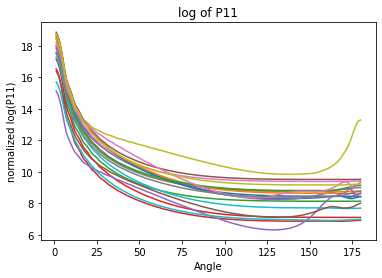

In [11]:
angle = np.arange(1,181)
plt.figure()
for i in range(len(Ensemble[1,:])):
    plt.plot(angle, np.log(Ensemble[:,i]))
plt.xlabel('Angle')
plt.ylabel('normalized log(P11)')
plt.title('log of P11')
plt.show()